In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.rcParams['font.sans-serif'] = 'SimHei'## 设置中文显示
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.DataFrame(pd.read_csv('./3.csv',sep = ',',encoding = 'gbk'))
data['支付时间'] = pd.to_datetime(data['支付时间'])
data['月份'] = [i.month for i in data['支付时间']]
df = pd.DataFrame(data['实际金额'].groupby([data['地点'],data['大类'],data['月份']]).sum()) #按地点、大类名称和月份分组获取交易总额数据

df.to_csv('预测训练集.csv',encoding = 'gbk')
traindata = pd.DataFrame(pd.read_csv('预测训练集.csv',sep = ',',encoding = 'gbk'))
traindata.columns = ['地点','大类','月份','交易总额']

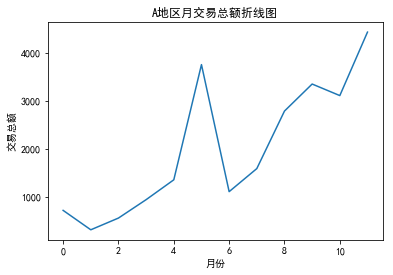

In [3]:
dataA1 = [] #A地区饮料类商品交易总额
for i in range(len(traindata)):
    if traindata['地点'][i] == 'A':
        if traindata['大类'][i] == '饮料':
            dataA1.append(traindata['交易总额'][i])

#对数据进行一阶差分
diffA1 = []
for i in range(1,len(dataA1)):
    diffA1.append(dataA1[i]-dataA1[i-1])

#绘制A地区饮料月交易额
plt.xlabel('月份')
plt.ylabel('交易总额')
plt.title('A地区月交易总额折线图')
plt.plot(dataA1)
plt.savefig('A地区月交易总额折线图.png')
#

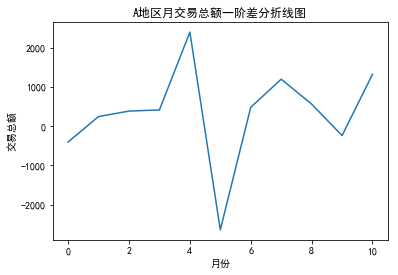

In [4]:
##绘制一阶差分图
plt.xlabel('月份')
plt.ylabel('交易总额')
plt.title('A地区月交易总额一阶差分折线图')
plt.plot(diffA1)
plt.savefig('A地区月交易总额一阶差分折线图.png')

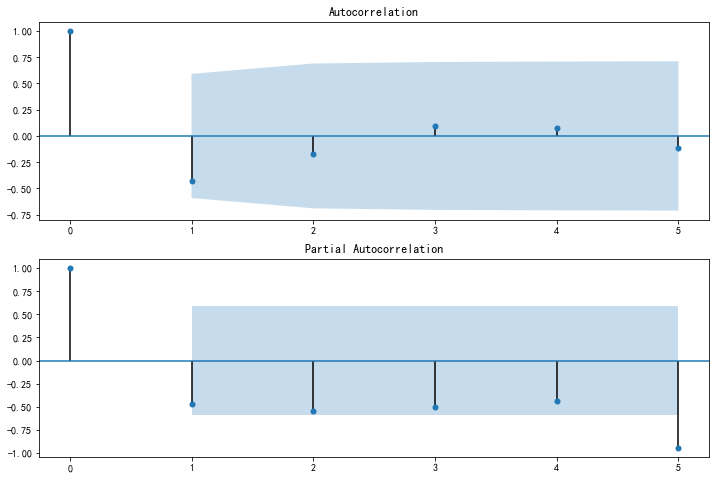

In [9]:
#设置以月为频率的时间索引
diffA1 = pd.DataFrame(diffA1,columns = ['差分价格'], index = pd.date_range('2017-02',periods = 11,freq = 'M'))
#绘制自相关图和偏自相关图
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diffA1,lags=5,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diffA1,lags=5,ax=ax2)
plt.savefig('A地区自相关与偏自相关图.png')

In [6]:
arima = sm.tsa.ARMA(diffA1,(0,1)).fit() #根据自相关图和偏自相关图确定模型阶数并拟合

print('D-W检验值为：',sm.stats.durbin_watson(arima.resid.values))

D-W检验值为： 2.2250315966747496


2017-12-31    646.861858
2018-01-31    324.075684
Freq: M, dtype: float64


D:\python\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
D:\python\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:342: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
D:\python\Anaconda\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


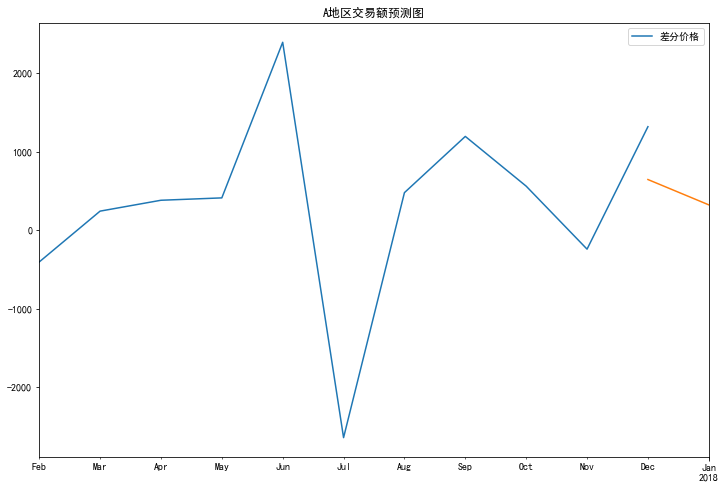

In [7]:
#绘制原差分价格及预测差分价格折线图
predict_data = arima.predict('2017-12', '2018-01', dynamic=True)
print(predict_data)
fig, ax = plt.subplots(figsize=(12, 8))
plt.title('A地区交易额预测图')
ax = diffA1.ix['2017-02':].plot(ax=ax)
predict_data.plot(ax=ax)
plt.savefig('A地区交易额预测图.png')

In [8]:
print('A地区2017年12月饮料类商品的实际销售总额为：',round(dataA1[11],2))
print('A地区2017年12月饮料类商品的预测销售总额为：',round(dataA1[10]+predict_data[0],2))
print('A地区2018年1月饮料类商品的预测销售总额为：',round(dataA1[11]+predict_data[1],2))

A地区2017年12月饮料类商品的实际销售总额为： 4424.8
A地区2017年12月饮料类商品的预测销售总额为： 3751.66
A地区2018年1月饮料类商品的预测销售总额为： 4748.88
